In [2]:
conda clean -tipsy

    Use 'conda build purge-all' to remove source cache files.
Cache location: 
There are no tarballs to remove
Cache location: 
There are no unused packages to remove

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
#import tensorflow_datasets as tfds
#from sklearn.model_selection import train_test_split

import numpy as np
from numpy import asarray

import matplotlib.pyplot as plt 
from matplotlib import image

import random as rd
import math as m
from PIL import Image
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import requests as req
import csv
import os
print(os.getcwd())

import copy

print(tf.__version__)


/Users/babi/Documents/GitHub/Quickdraw1/training_quickdraw
2.4.0


In [1]:
def download_npy(categories,number_of_samples):

    number_of_categories = len(categories)
    data = np.array([], dtype=np.int64).reshape(0,784)
    for i in range(number_of_categories):
        filename = categories[i][0] + '.npy'
        filename = filename.replace(" ","%20")
        
        url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'+filename
        
        r = req.get(url, allow_redirects=True)
        #filename = os.path.basename(url)
        #filename = filename.replace("%20","")
        open(filename, 'wb').write(r.content)
        
        data = np.vstack([data,load_data(filename,number_of_samples)])
        
        os.remove(filename)
        print(i+1,'/',number_of_categories,' ',filename.replace("%20",""))
    return data

def load_data(name,n):
    filename = name
    label = name
    data = np.load(filename)
    #data = np.ndarray.reshape(data,len(data),28,28)
    return data[0:n,:]

#randomize data and labels
def shuff(data,label,seed):
    
    s = np.shape(data)
    n = s[0]
    
    l = len(label)
    label_new = np.zeros(l)
    
    if len(2*s)==2:
        d = 1
        m = 1
        data_new = np.zeros((n,m))

    elif len(2*s)==4:
        d = 2
        m = s[1]
        data_new = np.zeros((n,m))
    
    
    l1 = list(range(n))
    l2 = list(range(n))
    np.random.seed(seed)
    np.random.shuffle(l1)
    np.random.seed(seed)
    np.random.shuffle(l2)   
    
    for i in range(n):
        data_new[i] = data[l1[i]]
        label_new[i] = int(label[l2[i]])
        
    del data, label
    return data_new, label_new

def download_and_save(number_of_categories,number_of_samples):

    x = [random.randint(0, 345) for p in range(0, number_of_categories)]

    #load categories
    categories = open("categories.txt",'r')
    reader = csv.reader(categories)
    categories = [row for row in reader]
    categories = [categories[row] for row in x]
    
    d = download_npy(categories,number_of_samples)
    
    #save Data
    filename = 'dataset/data_{}_{}.csv'.format(number_of_categories,number_of_samples)
    np.savetxt(filename, d, delimiter=',')
    
    #save Categories
    filename = 'dataset/cat_{}_{}.csv'.format(number_of_categories,number_of_samples)
    with open(filename, 'w') as f: 
        write = csv.writer(f) 
        write.writerows(categories)
    return d, categories
    
def data_from_file(number_of_categories,number_of_samples):
    
    filename = 'dataset/data_{}_{}.csv'.format(number_of_categories,number_of_samples)
    d = np.loadtxt(filename, delimiter=',')
    filename = 'dataset/cat_{}_{}.csv'.format(number_of_categories,number_of_samples)
    categories = open(filename,'r')
    reader = csv.reader(categories)
    categories = [row for row in reader]
    
    return d, categories

In [9]:
number_of_categories = 5
number_of_samples = 100

##load data
#d, cats = download_and_save(number_of_categories,number_of_samples)
d, cats = data_from_file(number_of_categories,number_of_samples)

cat_id = np.repeat(range(number_of_categories),number_of_samples)+1

print('Categories: ', cats)
print(np.shape(d),' ',np.shape(cat_id))


Categories:  [['bucket'], ['bridge'], ['bracelet'], ['coffee cup'], ['streetlight']]
(500, 784)   (500,)


In [21]:
#Shuffle data
data,cat_id = shuff(d,cat_id,13)

#reshape data into 28x28
data = np.reshape(data,(len(data),28,28))
print(np.shape(data),' ',np.shape(cat_id))


(500, 28, 28)   (500,)


In [18]:
data = np.reshape(d,(len(d),28,28))

In [22]:
#split data
training = 0.8
test = 1.-training

x_train = data[0:m.floor(training*len(data))]/ 255.0
y_train = cat_id[0:m.floor(training*len(cat_id))]

x_test = data[m.ceil(training*len(data)):len(data)]/ 255.0
y_test = cat_id[m.ceil(training*len(cat_id)):len(cat_id)]

print('Train-Set: ','Samples',np.shape(x_train)[0],'/ Labels', np.shape(y_train)[0])
print('Test-Set: ','Samples',np.shape(x_test)[0],'/ Labels', np.shape(y_test)[0])

Train-Set:  Samples 400 / Labels 400
Test-Set:  Samples 100 / Labels 100


['coffee cup'] 219


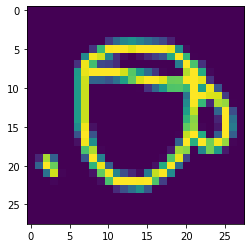

In [23]:
#TEST Show
i=rd.randint(1,len(x_train))
plt.imshow(x_train[i])
print(cats[int(cat_id[i]-1)],i)

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(number_of_categories),
  tf.keras.layers.Softmax()
])

#define lossfunction
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile: set optimizer, lossfunction, error metric
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

#train the model
model.fit(x_train, y_train,batch_size = 50, epochs=5)

Epoch 1/5


In [44]:
batch_size = 100
len(x_train)/batch_size

40.0

In [41]:
model.evaluate(x_test,  y_test, verbose=2);

32/32 - 0s - loss: 2.2234 - accuracy: 0.2110


In [2]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(number_of_categories),
  tf.keras.layers.Softmax()
])

#define lossfunction
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


# Compile and Fit in Batches
x_train_len = len(x_train)
y_train_len = len(y_train)
#x_test_len = len(x_test)
#y_test_len = len(y_test)

batches = int(number_of_categories*number_of_samples/10)
end = -1
for i in range(batches):
    
    start = int(end+1)
    end = int((i+1)*1/batches*x_train_len)
    
    x_train2 = x_train[start:end,:,:].copy()
    y_train2 = y_train[start:end].copy()
    #x_test = x_test[start:end,:]
    #y_test = y_test[start:end]

    # Run with new data
    model.compile(optimizer='adam',
                  loss=loss_fn,
                  metrics=['accuracy'])
    
    if i%10:
        print('Batch No. ',i,'/',batches)
    model.fit(x_train2, y_train2, epochs=5, verbose=0)

NameError: name 'tf' is not defined

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(number_of_categories),
  tf.keras.layers.Softmax()
])

#define lossfunction
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Run with new data
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])
model.fit(x_train2, y_train2, batch_size=5, epochs=5)

Epoch 1/5


In [1]:
model.evaluate(x_test,  y_test, verbose=2);

NameError: name 'model' is not defined

In [25]:
int(number_of_categories*number_of_samples/10)

500

In [ ]:
name = "qd.h5"
saved_model_dir = 'save/'+str(name)
model.save(saved_model_dir)
print('Model Saved to '+saved_model_dir)

In [ ]:
#tf.saved_model.save(model,'save/')
#converter = tf.lite.TFLiteConverter.from_keras_model_file(model)
#Use this if 238 fails 
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
model.save('save/qd_0')


In [ ]:
model.summary()


In [ ]:
new_model = tf.keras.models.load_model('save/qd_0')
new_model.summary()


In [ ]:
new_model.evaluate(x_test,  y_test, verbose=2);


In [ ]:
predictions = new_model.predict(x_test)

In [ ]:
i=2
print(labels[np.argmax(predictions[i])])
plt.figure()
plt.imshow(x_test[i])
plt.show()

In [ ]:
#Show PNG
image = Image.open('dataset/airplane3.png')
# convert image to numpy array
data = asarray(image)
data = abs(data-255.)/255.

# summarize shape
print(data.shape)
plt.imshow(image)
plt.show()



In [ ]:
#Convert png to 28x28 array
image = Image.open('dataset/airplane3.png')
image_resize = image.resize((28,28))
data_resize = asarray(image_resize)
data_resize = abs(data_resize-255.)/255.
data_resize = data_resize[:, :, 0]
data_resize = np.expand_dims(data_resize, axis=0)

#Predict png
predictions = new_model.predict(data_resize)
print(labels[np.argmax(predictions)])
print(data_resize.shape)
plt.imshow(image_resize)
plt.show()
